# DDPM Editing Experiment

This experiment aims at exploring the DDPM model's ability to edit images similar to the paper [SDEdit](https://github.com/ermongroup/SDEdit). 

There are two edit mode we are exploring in this notebook.
- **Global Editing**, where we edit the entire image.
- **Partial Editing**, where we edit a part of the image based on a mask. 

For both modes, we will test how the number of forward diffusion steps affects the quality (and diversity) of the generated image. 

For partial editing, we will additionally test the effect of the mask size on the quality (and diversity) of the generated image. 


In [1]:
import matplotlib.pyplot as plt
from models.viz_utils import save_sampling_video, visualize_elevation_map, visualize_leveled_elevation_map, visualize_elevation_map_pyploy
from data_script.elevation_dataset import ElevationDataset
from models.ddpm_edit import Editor
import torch
from models.util import ScaleToRange, scale_to_range
import numpy as np
%load_ext autoreload
%autoreload 2

/home/sp/anaconda3/envs/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
# original dataset, the output is scaled to [-1, 1]
dataset = ElevationDataset('/home/sp/isaacgym/sim-to-real-offroad/assets/elevation')
# we use the same editor for both global and partial editing
editor = Editor("/home/sp/terrain/denoising-diffusion-pytorch/results/model-12.pt")

torch.Size([1, 128, 128]) 0.9506898801931978


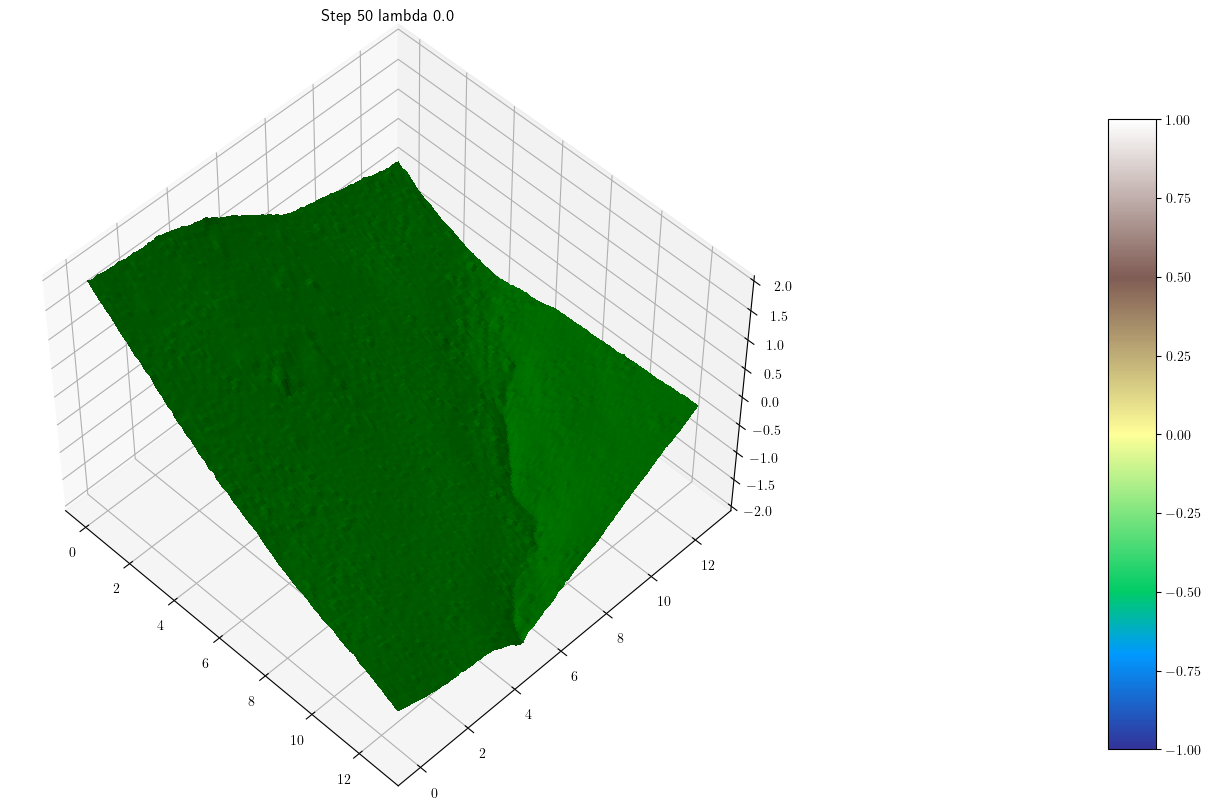

In [51]:
# randomly choose one terrain image to edit from the dataset
random_index = np.random.randint(0, len(dataset))
original_data_sample, ratio = dataset[random_index]
original_data_sample = original_data_sample.to("cuda")
print(original_data_sample.shape, ratio)
visualize_elevation_map(original_data_sample, 1, 1, subtitles="Original")#, save_dir="./test_imgs/original.png")

In [25]:
import random
from PIL import Image, ImageDraw
import random
from PIL import Image, ImageDraw


def check_overlap(mask, shape_bbox):
    x1, y1, x2, y2 = shape_bbox
    subarea = mask.crop((x1, y1, x2, y2))
    return subarea.getbbox() is not None


def generate_mask(H, W, mask_area_ratio):
    mask = Image.new('1', (W, H), 0)
    draw = ImageDraw.Draw(mask)

    target_area = H * W * mask_area_ratio
    current_area = 0

    while True:
        shape = random.choice(['circle', 'rectangle', 'polygon'])
        new_area = 0
        bbox = ()

        if shape == 'circle':
            x1, y1 = random.randint(0, W), random.randint(0, H)
            r = random.randint(1, min(W, H) // 6)
            bbox = (x1 - r, y1 - r, x1 + r, y1 + r)
            new_area = round(3.14159 * r * r)

        elif shape == 'rectangle':
            x1, y1 = random.randint(0, W//2), random.randint(0, H//2)
            x2, y2 = random.randint(x1, W//2), random.randint(y1, H//2)
            bbox = (x1, y1, x2, y2)
            new_area = abs((x2 - x1) * (y2 - y1))

        elif shape == 'polygon':
            points_num = random.randint(3, 6)
            points = [(random.randint(0, W//2), random.randint(0, H//2)) for _ in range(points_num)]
            bbox = tuple(map(min, zip(*points))) + tuple(map(max, zip(*points)))

            # Calculate the area of the polygon using Shoelace formula
            x, y = zip(*points)
            new_area = int(0.5 * abs(sum(x[i - 1] * y[i] - x[i] * y[i - 1] for i in range(points_num))))
        if current_area + new_area <= target_area:
            if shape == 'circle':
                draw.ellipse(bbox, fill=1)
            elif shape == 'rectangle':
                draw.rectangle(bbox, fill=1)
            elif shape == 'polygon':
                draw.polygon(points, fill=1)
            current_area += new_area
        else:
            break

        if current_area >= target_area:
            break
    return mask

def generate_mask_by_gradient(H, W, mask_area_ratio, map_txt):
    mask = np.zeros_like(map_txt[0])
    # mask = Image.fromarray(map_txt[0])

    target_area = H * W * mask_area_ratio

    gradient = np.abs(np.gradient(map_txt[0]))
    gradient = np.sqrt(np.square(gradient[0]) + np.square(gradient[1]))
    # gradient = np.abs(np.gradient(gradient))
    # gradient = np.add(gradient[0], gradient[1])
    min_grad_indices = np.dstack(np.unravel_index(np.argsort(gradient.ravel()), gradient.shape))[0]
    grad_filter = set()
    r = 10
    for id in range(128 * 128):
        xx = min_grad_indices[id][0]
        yy = min_grad_indices[id][1]
        for rr in range(-r+1, r):
            y1 = yy + rr
            for r1 in range(abs(rr)-r+1, r-abs(rr)):
                x1 = xx + r1
                if x1>=0 and x1<128 and y1>=0 and y1<128:
                    # print(len(grad_filter), target_area)
                    if len(grad_filter) >= target_area:
                        break
                    if map_txt[0][x1][y1] >= 0:
                        grad_filter.add((x1, y1, 1))
                    else:
                        grad_filter.add((x1, y1, -1))
    for id in grad_filter:
        mask[id[0]][id[1]] = id[2]
    return mask

In [5]:
# preparations 
mask_area_ratio = [0.4]#, 0.4, 0.6, 1.0, 1.2, 1.6, 2.0]
num_samples = 1
repeated_original_data_sample = original_data_sample.unsqueeze(dim=0).repeat(num_samples, 1, 1, 1)
# ts = torch.tensor([50, 100, 200, 400, 800, 1000], device=torch.device("cuda"))
# ts = torch.tensor([50, 100, 200, 400], device=torch.device("cuda"))
ts = torch.tensor([500], device=torch.device("cuda"))

Mask ratios -0.3006591796875


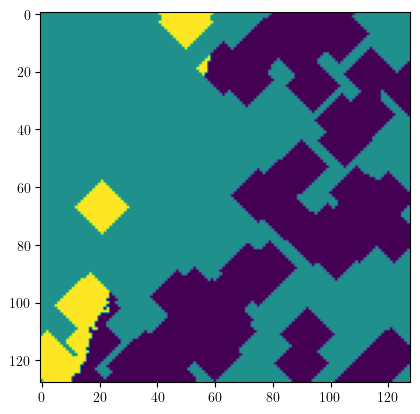

In [52]:
H, W = 128, 128
# the generated mask value is -1 and 0, where 0 means non-editable, and -1 means editable (masked out).
# since the mask ratio does not account for the overlapping area, it is possible that the actual mask ratio is smaller than the target ratio
masks = [np.array(generate_mask_by_gradient(H, W, mask_area_ratio[i], original_data_sample.cpu().numpy().copy())) for i in range(len(mask_area_ratio))]
# masks = [np.array(generate_mask(H, W, mask_area_ratio[i])) for i in range(len(mask_area_ratio))]
true_mask_ratio = []
for m in masks:
    print("Mask ratios", m.sum()/(H*W))
    true_mask_ratio.append(m.sum()/(H*W))
plt.imshow(masks[0])
plt.show()
# masks = [-torch.from_numpy(mask).view(1, 1, 128, 128).
#          repeat(num_samples, 1, 1, 1).
#          to("cuda").float() 
#          for mask in masks]
masks = [torch.from_numpy(mask).view(1, 1, 128, 128).
         repeat(num_samples, 1, 1, 1).
         to("cuda").float() 
         for mask in masks]

In [ ]:
# final shape should be (# of masks, # steps, # samples, # diffusion_steps, C, H, W)
mask_area_ratio = [0.2, 0.4, 0.6, 1.0, 1.2, 1.6, 2.0]
masks = [np.array(generate_mask(H, W, mask_area_ratio[i])) for i in range(len(mask_area_ratio))]
true_mask_ratio = []
for m in masks:
    true_mask_ratio.append(m.sum()/(H*W))
masks = [torch.from_numpy(mask).view(1, 1, 128, 128).
         repeat(num_samples, 1, 1, 1).
         to("cuda").float() 
         for mask in masks]

all_edited_samples = []
for mask in masks:
    edited_samples = []
    for i in range(300, 401, 20):
        edited_x, all_edited_x = editor(repeated_original_data_sample, i, keep_intermediate=True, mask=None)#mask)
        edited_samples.append(all_edited_x.cpu().detach().numpy())
        print("Shape", all_edited_x.shape)
    all_edited_samples.append(edited_samples)

In [ ]:
def extract_final_sample(sample_seq):
    final_edited_samples = sample_seq[:, -1]
    if isinstance(sample_seq, torch.Tensor):
        # final_edited_samples = torch.stack(final_edited_samples, dim=0)
        final_edited_samples = final_edited_samples.view(-1, 128, 128)
    else:
        # final_edited_samples = np.stack(final_edited_samples, axis=0)
        final_edited_samples = final_edited_samples.reshape(-1, 128, 128)
    return final_edited_samples

In [ ]:
sample_1 = extract_final_sample(all_edited_samples[0][-1])
sample_2 = extract_final_sample(all_edited_samples[1][-1])
sample_3 = extract_final_sample(all_edited_samples[2][-1])
sample_4 = extract_final_sample(all_edited_samples[3][-1])
sample_5 = extract_final_sample(all_edited_samples[4][-1])
sample_6 = extract_final_sample(all_edited_samples[5][-1])
sample_7 = extract_final_sample(all_edited_samples[6][-1])
# visualize_elevation_map(sample_1[:4], 2, 2, title=f"Mask Area Ratio: {true_mask_ratio[0]}", save_dir="test_imgs/mask_0.2.png")

variances = np.array([
  np.var(sample_1, axis=0).sum()/masks[0][0].sum().item(),
  np.var(sample_2, axis=0).sum()/masks[1][0].sum().item(), 
  np.var(sample_3, axis=0).sum()/masks[2][0].sum().item(),
  np.var(sample_4, axis=0).sum()/masks[3][0].sum().item(),
  np.var(sample_5, axis=0).sum()/masks[4][0].sum().item(),
  np.var(sample_6, axis=0).sum()/masks[5][0].sum().item(),
  np.var(sample_7, axis=0).sum()/masks[6][0].sum().item()
]) 
fig, axis = plt.subplots(1, 1, figsize=(8, 5))
axis.plot(true_mask_ratio, variances, marker='o')
print(true_mask_ratio[0], np.var(sample_1, axis=0).sum())

In [65]:
## TEST
## from 50 to 1000 steps, how things change
all_edited_samples = []
for lamb in np.arange(0.1, 1, 0.1):
    edited_samples = []
    for i in range(50, 1000, 50):
        edited_x = editor(repeated_original_data_sample, i, keep_intermediate=False, mask=masks[0], lamb=0.5)
        edited_samples.append(edited_x[0].cpu().detach().numpy())
    all_edited_samples.append(edited_samples)

interpolation sample time step: 100%|██████████| 950/950 [00:09<00:00, 97.11it/s]


(19, 128, 128)


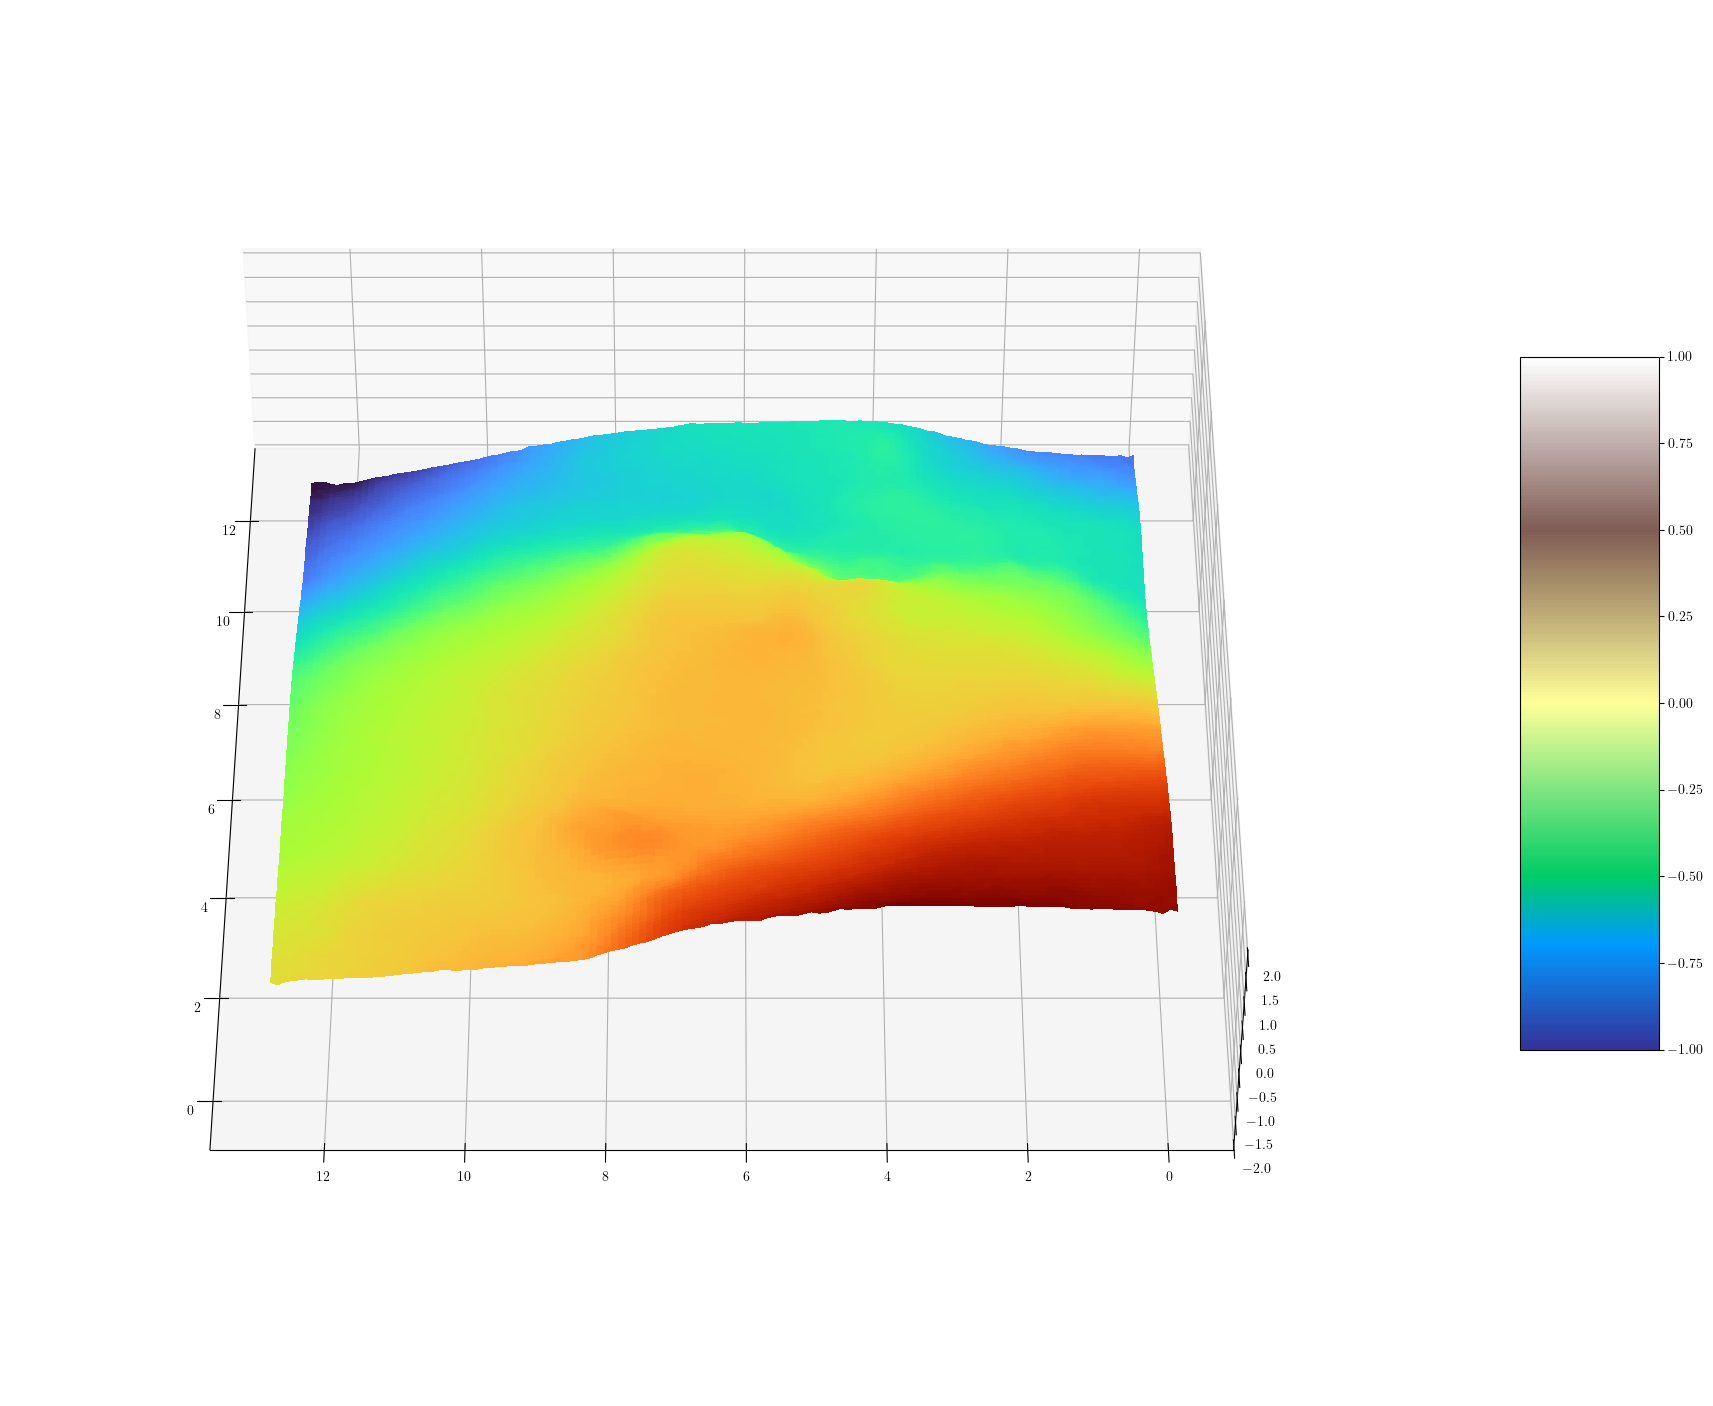

(19, 128, 128)


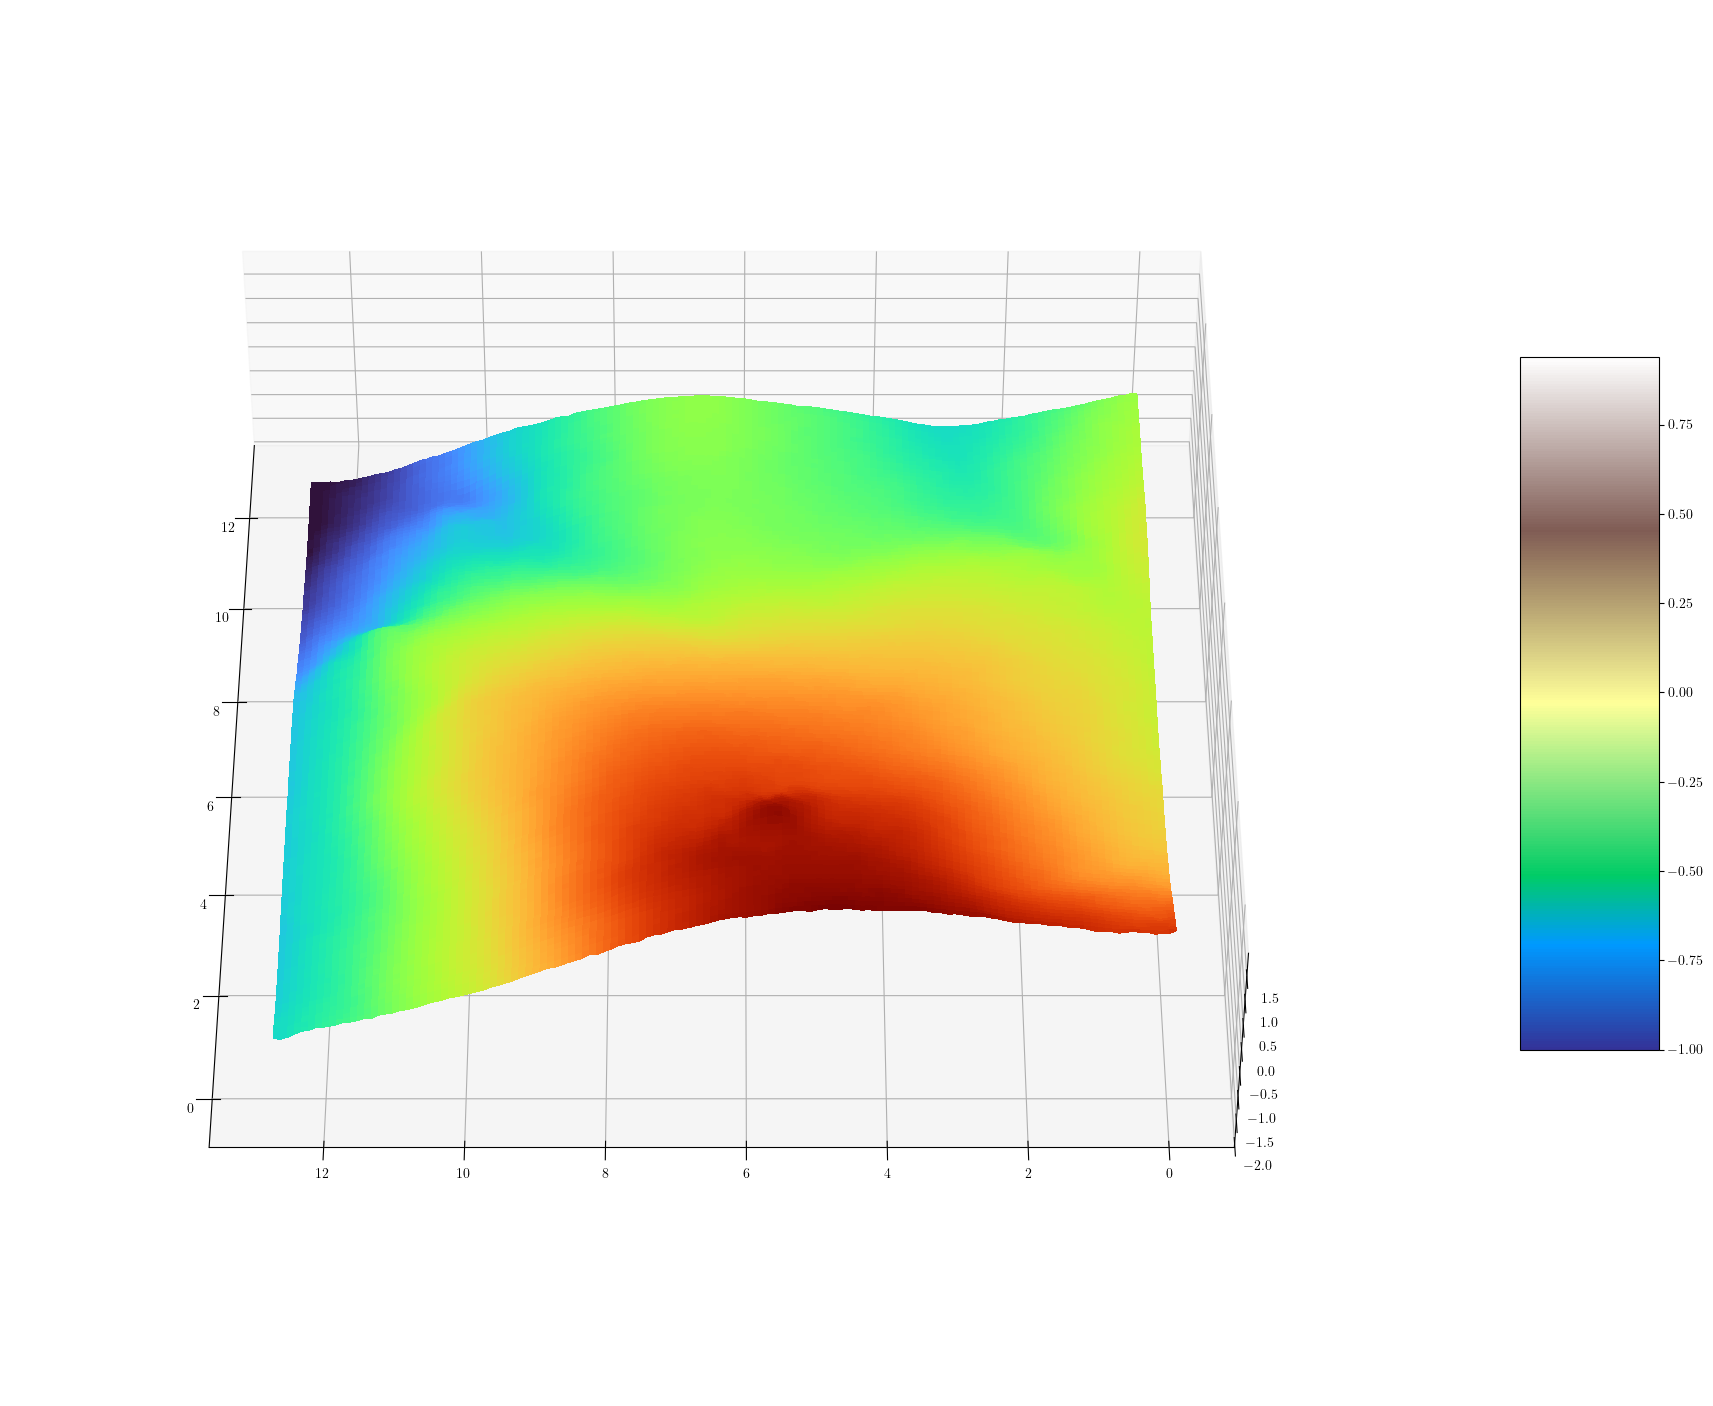

(19, 128, 128)


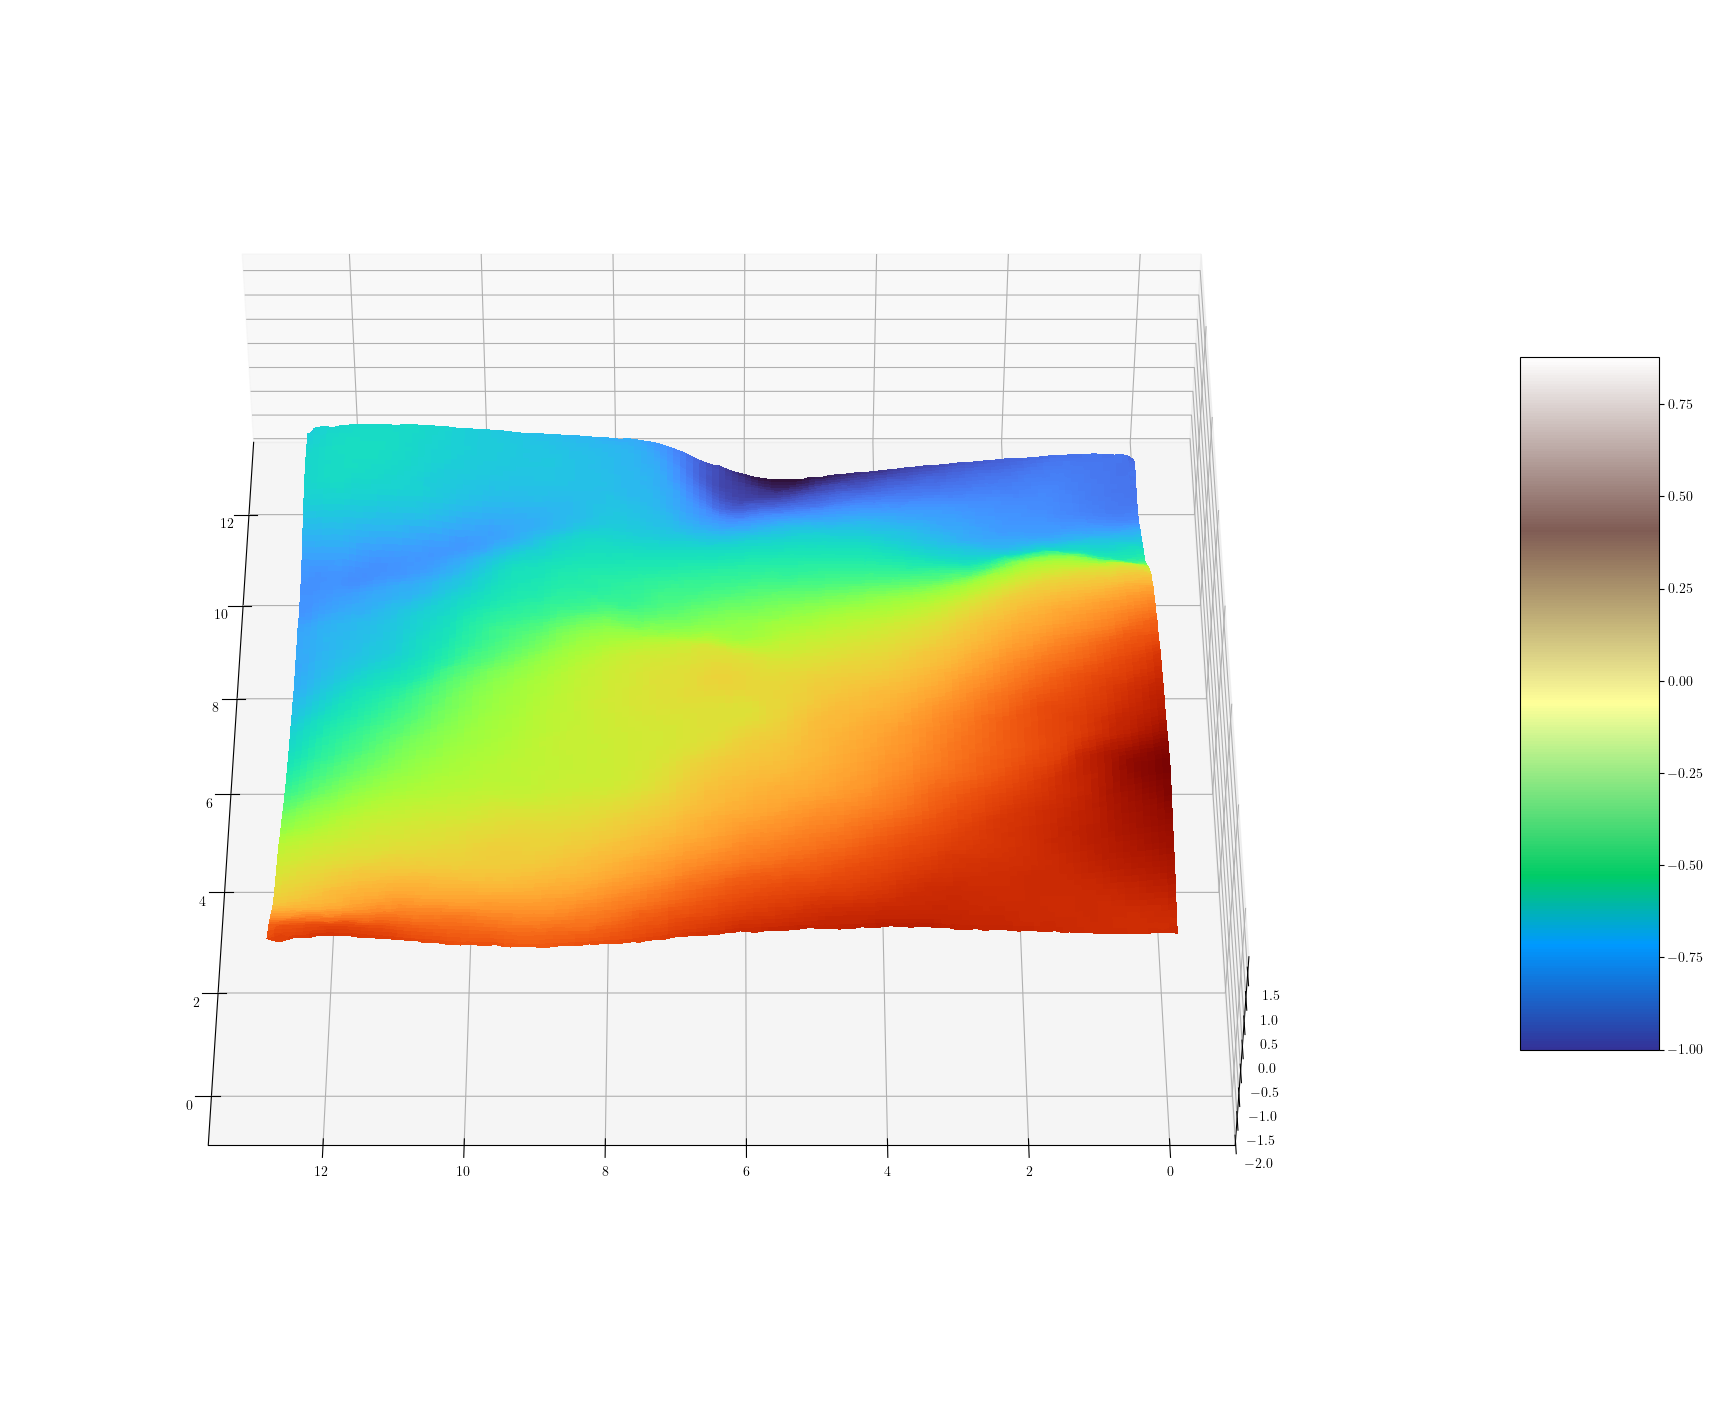

(19, 128, 128)


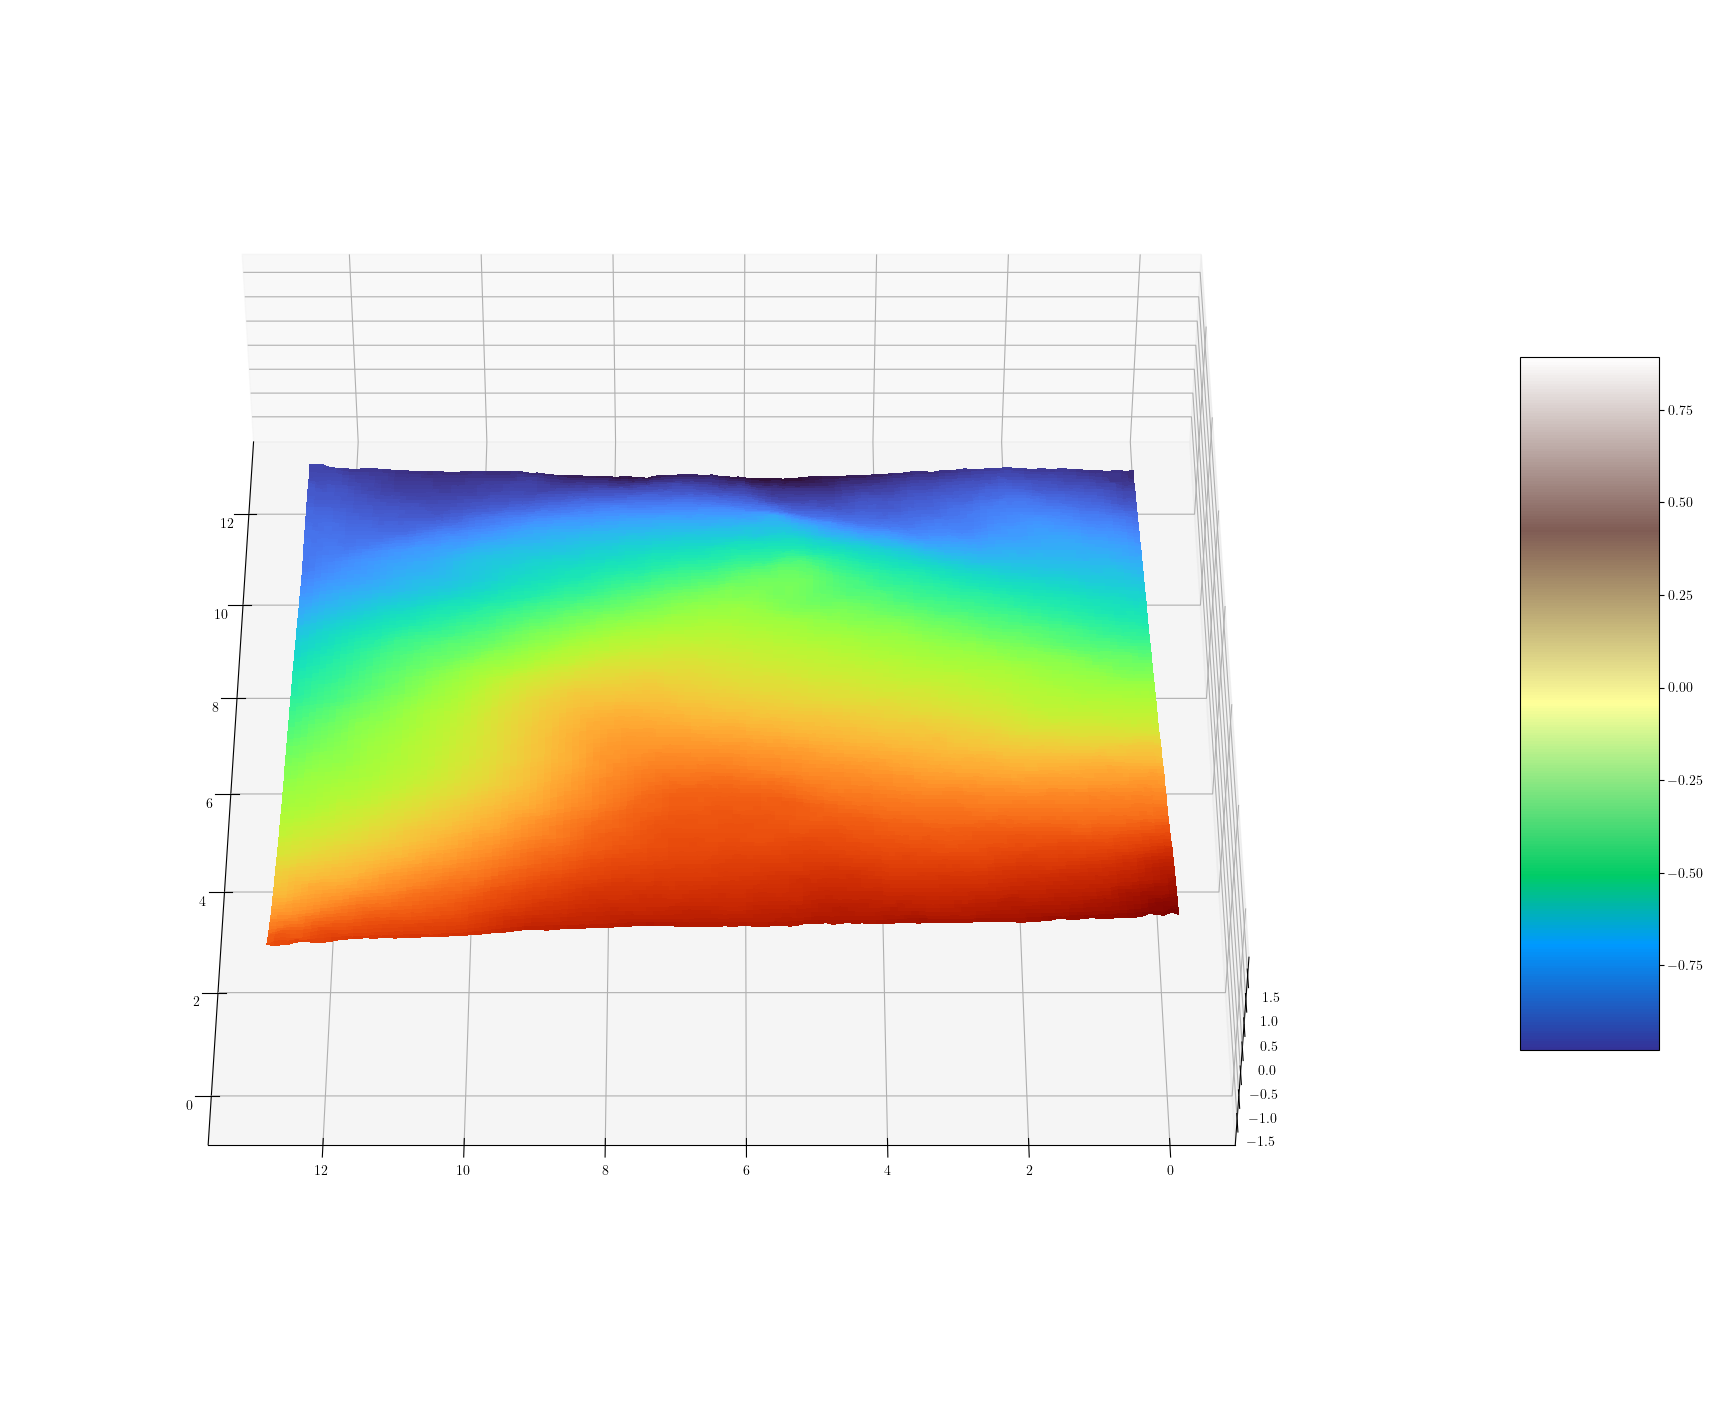

(19, 128, 128)


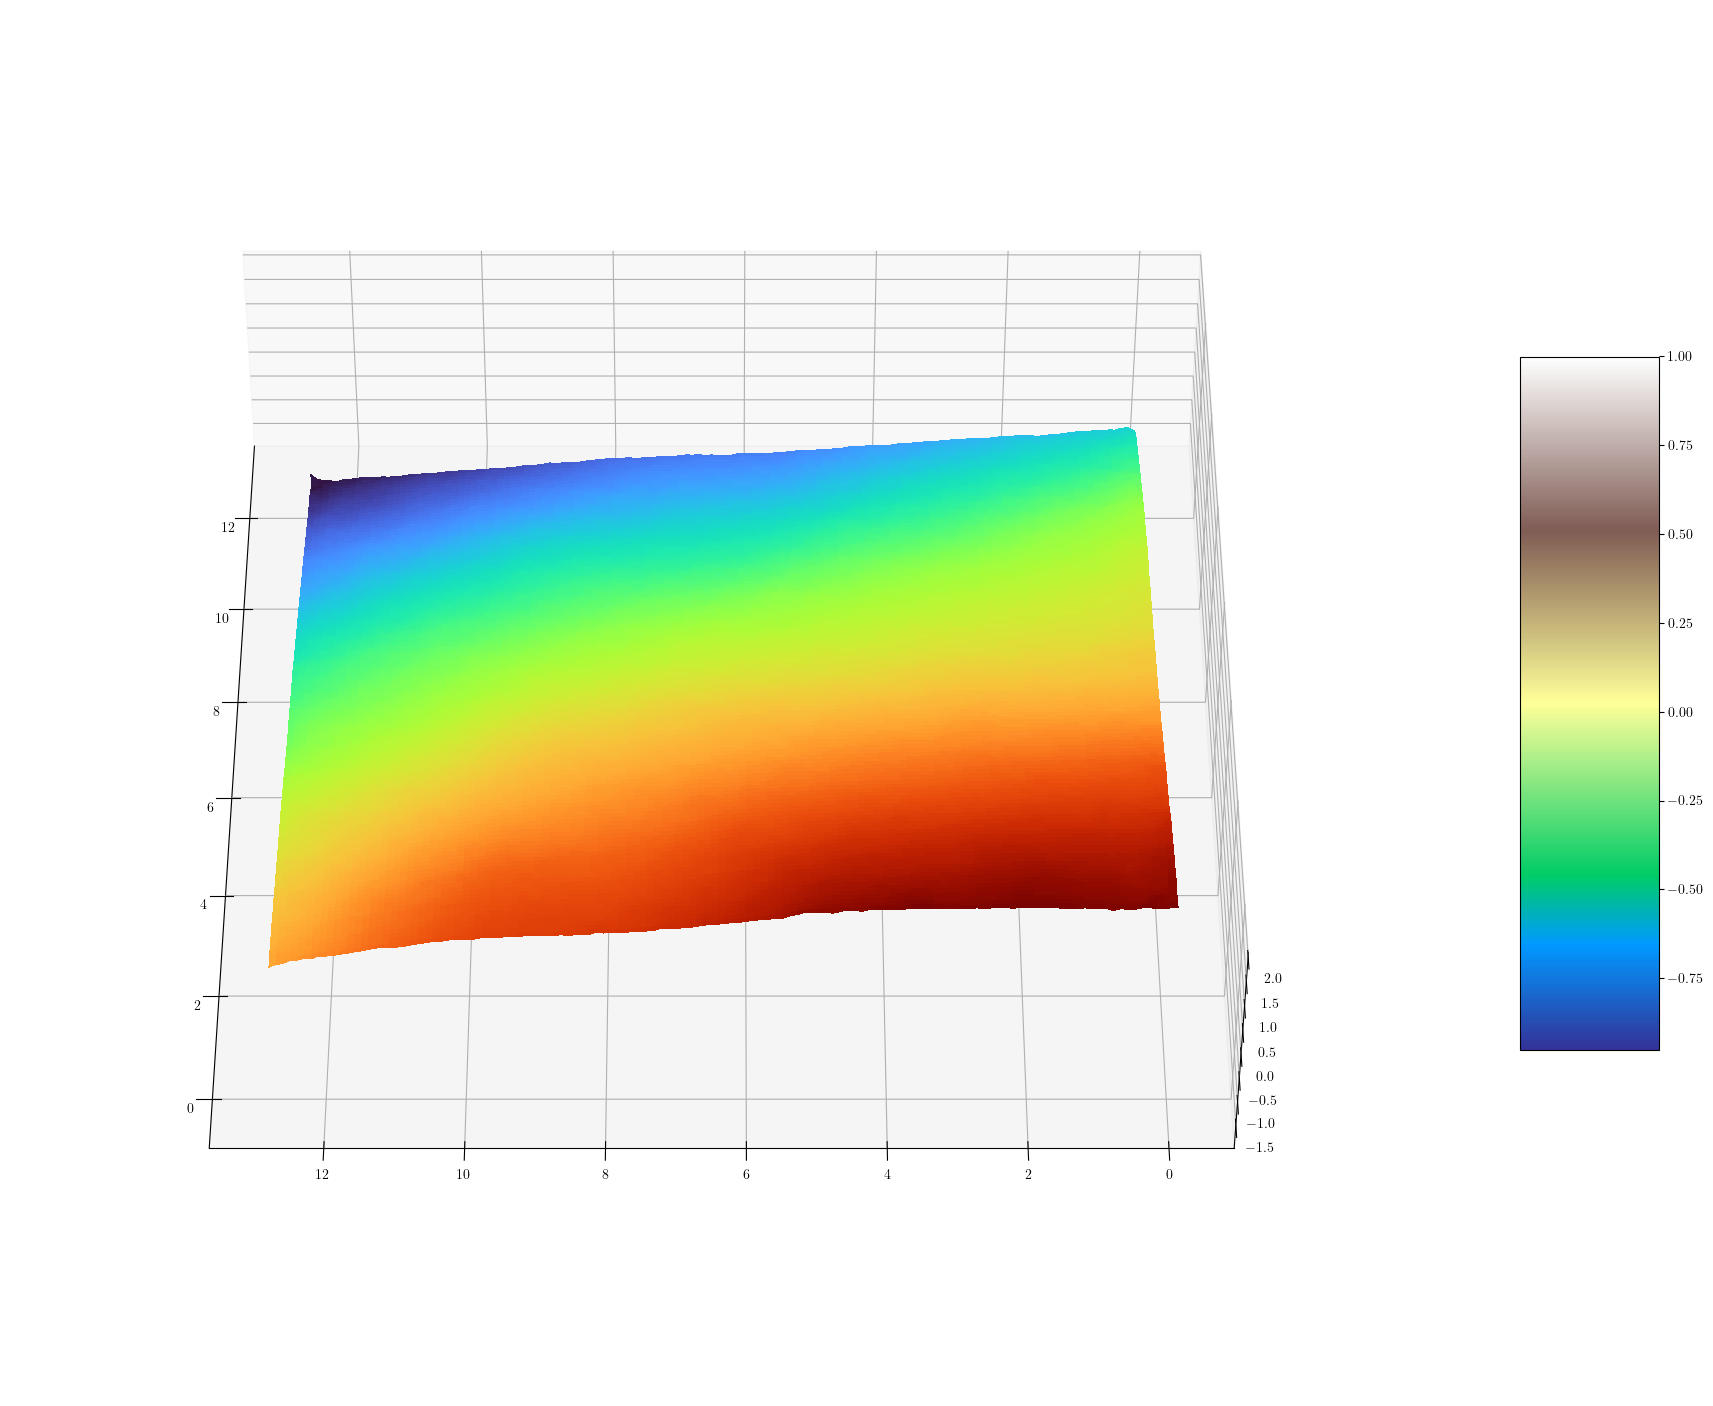

(19, 128, 128)


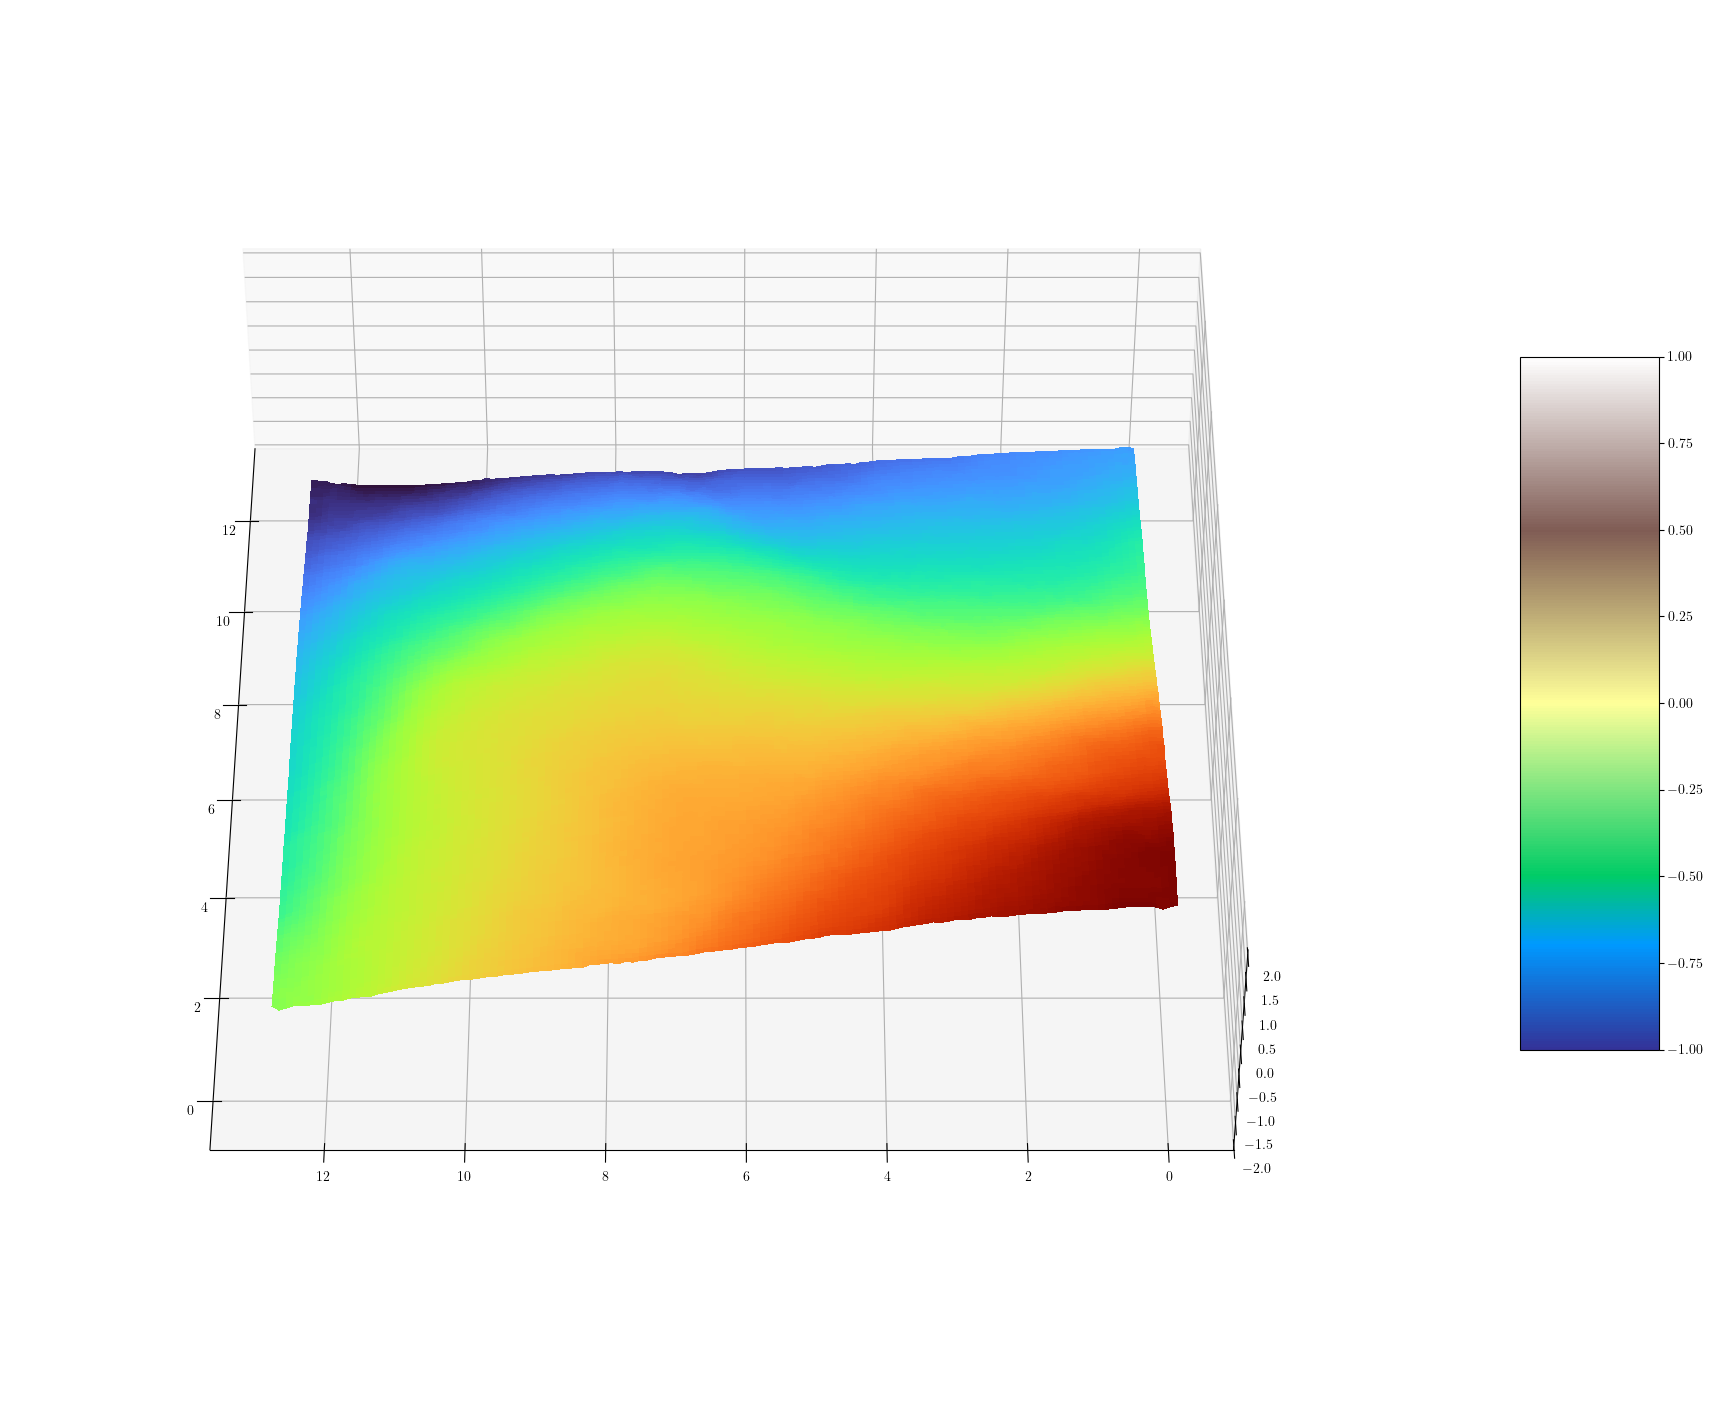

(19, 128, 128)


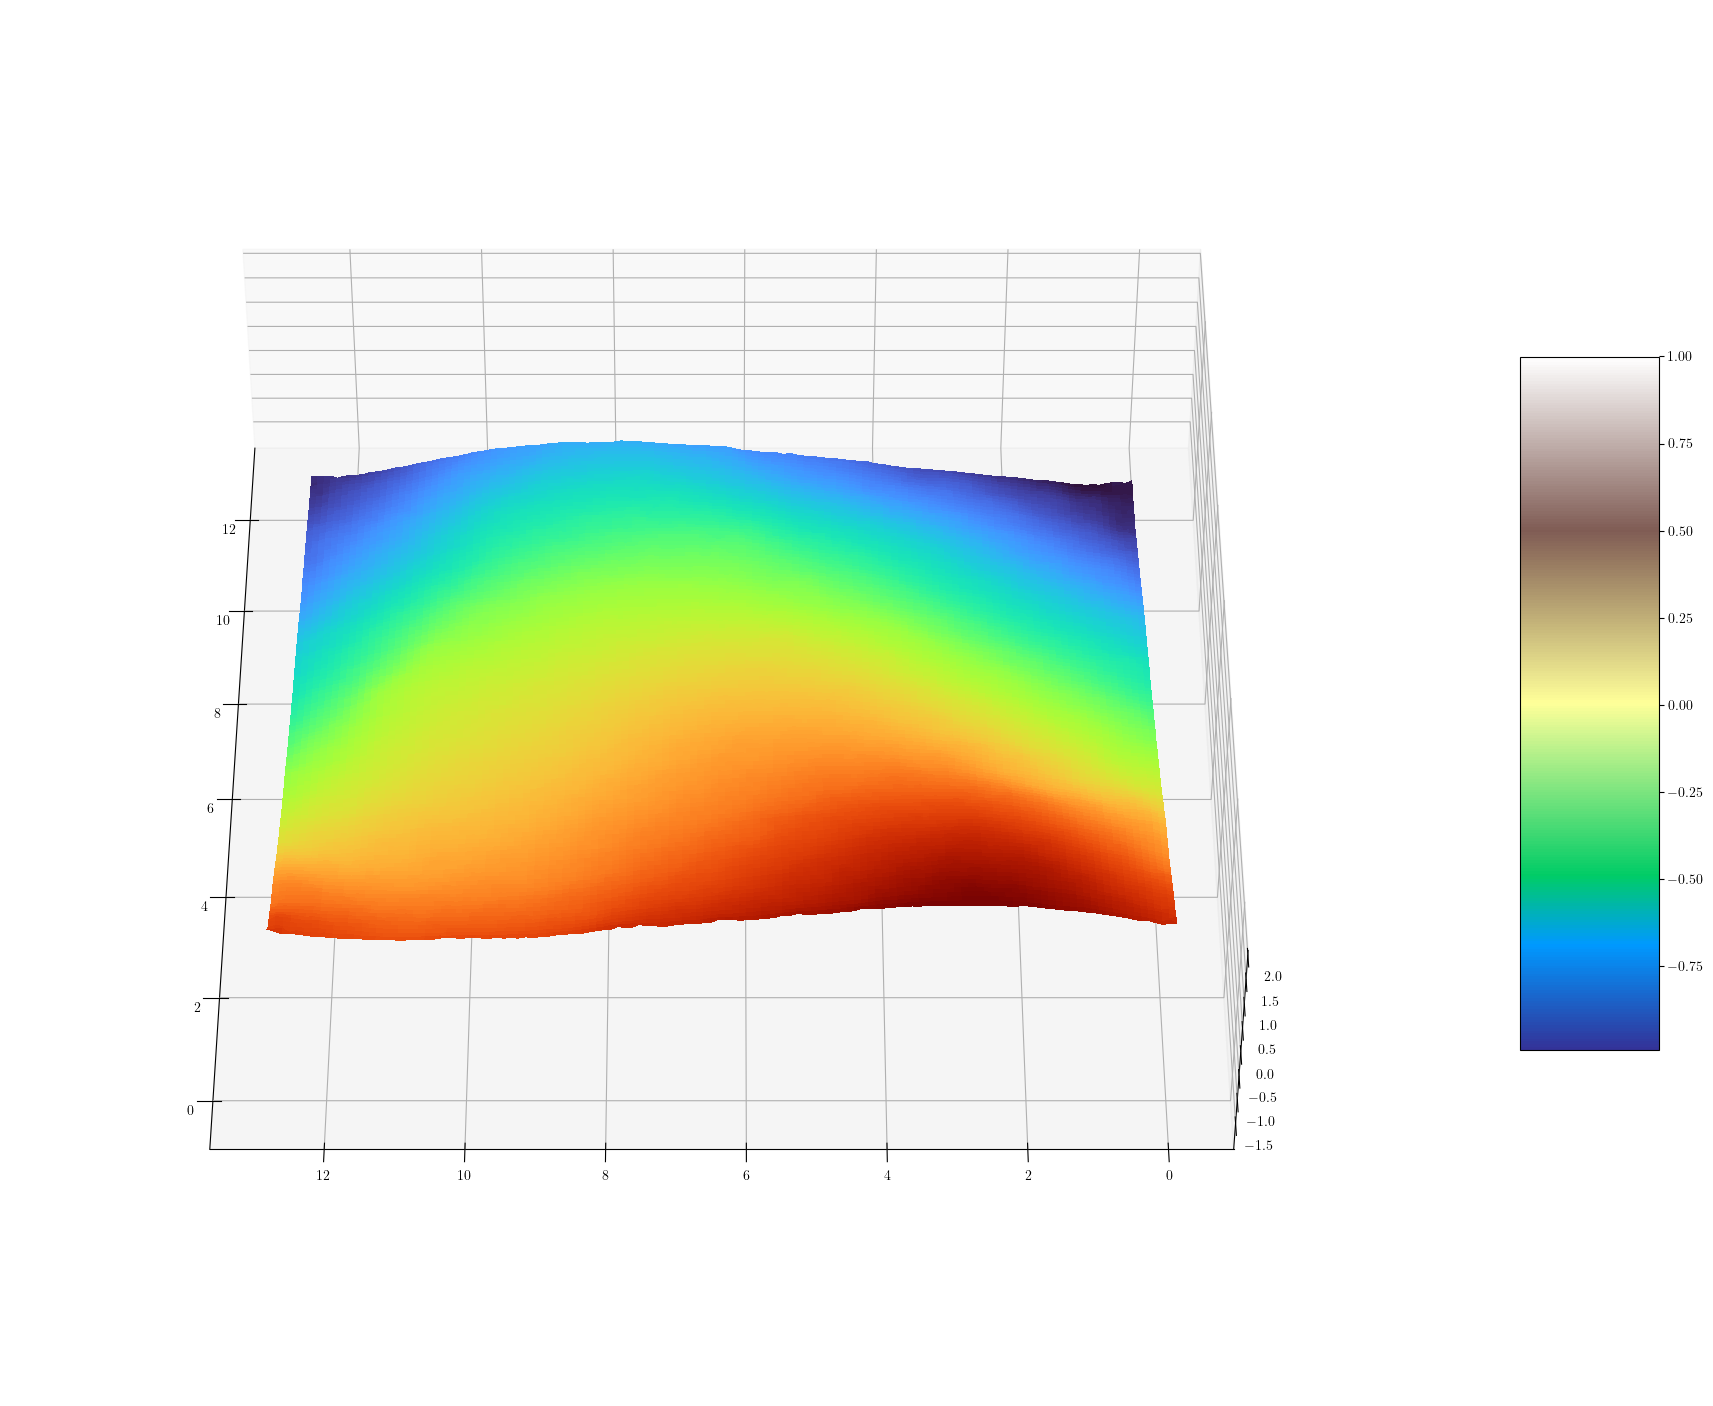

(19, 128, 128)


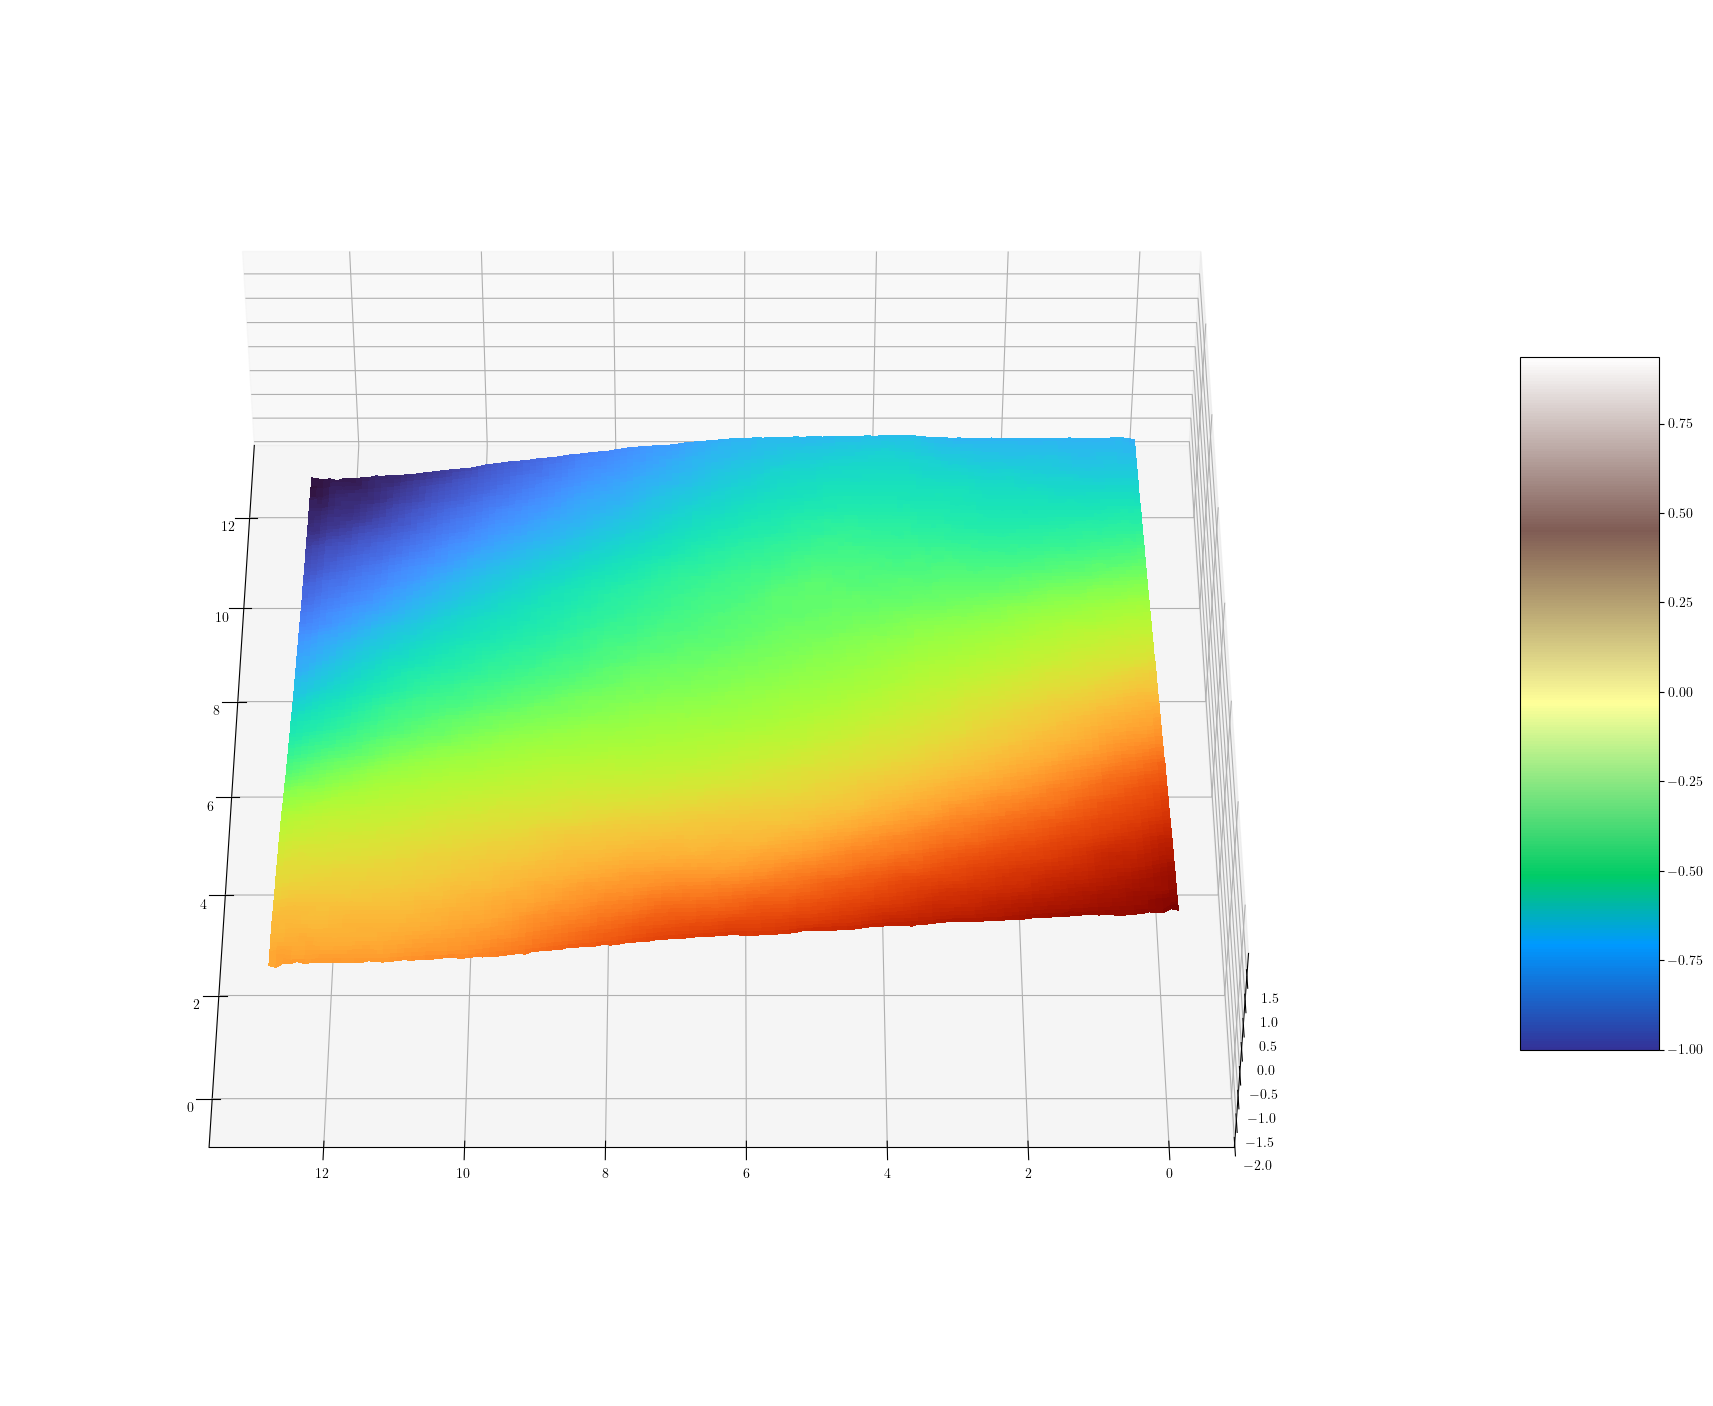

In [69]:
for j in range(1, len(all_edited_samples)):
    last_edited_samples = []
    for i in range(len(all_edited_samples[j])):
        last_edited_samples.append(all_edited_samples[j][i])

    save_sampling_video(np.array(last_edited_samples), "test_imgs/" + str(j) + ".mp4", len(all_edited_samples[0]))

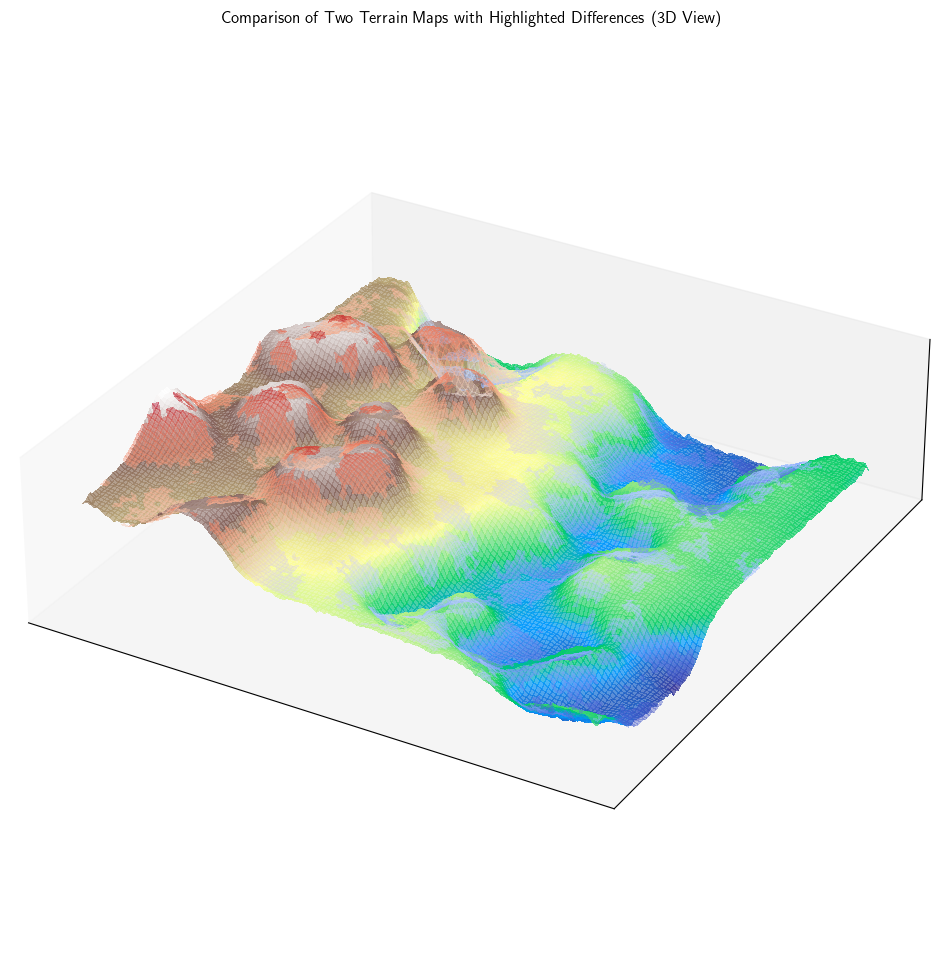

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load or generate your two terrain maps (replace these with your actual data)
terrain_map1 = all_edited_samples[0][0][0] * 2  # First terrain map (for demonstration)
terrain_map2 = all_edited_samples[0][1][0] * 2 # Second terrain map (partially different)

# Calculate the absolute difference between the two terrain maps
difference_map = np.abs(terrain_map1 - terrain_map2)

# Create a grid of X and Y values
X = np.arange(0, 12.8, 0.1)  # Adjust the range and step size based on your terrain size
Y = np.arange(0, 12.8, 0.1)
X, Y = np.meshgrid(X, Y)

# Create a figure and 3D axis for plotting
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot for the first terrain map without grid lines
surf1 = ax.plot_surface(X, Y, terrain_map1, cmap='terrain', alpha=0.7, rstride=1, cstride=1, linewidth=0, antialiased=False, edgecolor='none')

# Create a colormap for highlighting the differences more distinctly
cmap_diff = plt.get_cmap('coolwarm')

# Overlay the second terrain map with only the different parts using the difference map
# Set the elevations to NaN where there are no differences
terrain_map2_with_diff = np.where(difference_map > 0.05, terrain_map2, np.nan)
surf_diff = ax.plot_surface(X, Y, terrain_map2_with_diff, cmap=cmap_diff, alpha=0.4, rstride=1, cstride=1, linewidth=0, antialiased=False)

# Remove axis labels, ticks, and grid
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.grid(False)

# Set the title
ax.set_title('Comparison of Two Terrain Maps with Highlighted Differences (3D View)')
ax.set_aspect('equal')

# Show the plot
plt.show()

(19, 128, 128)


KeyboardInterrupt: 

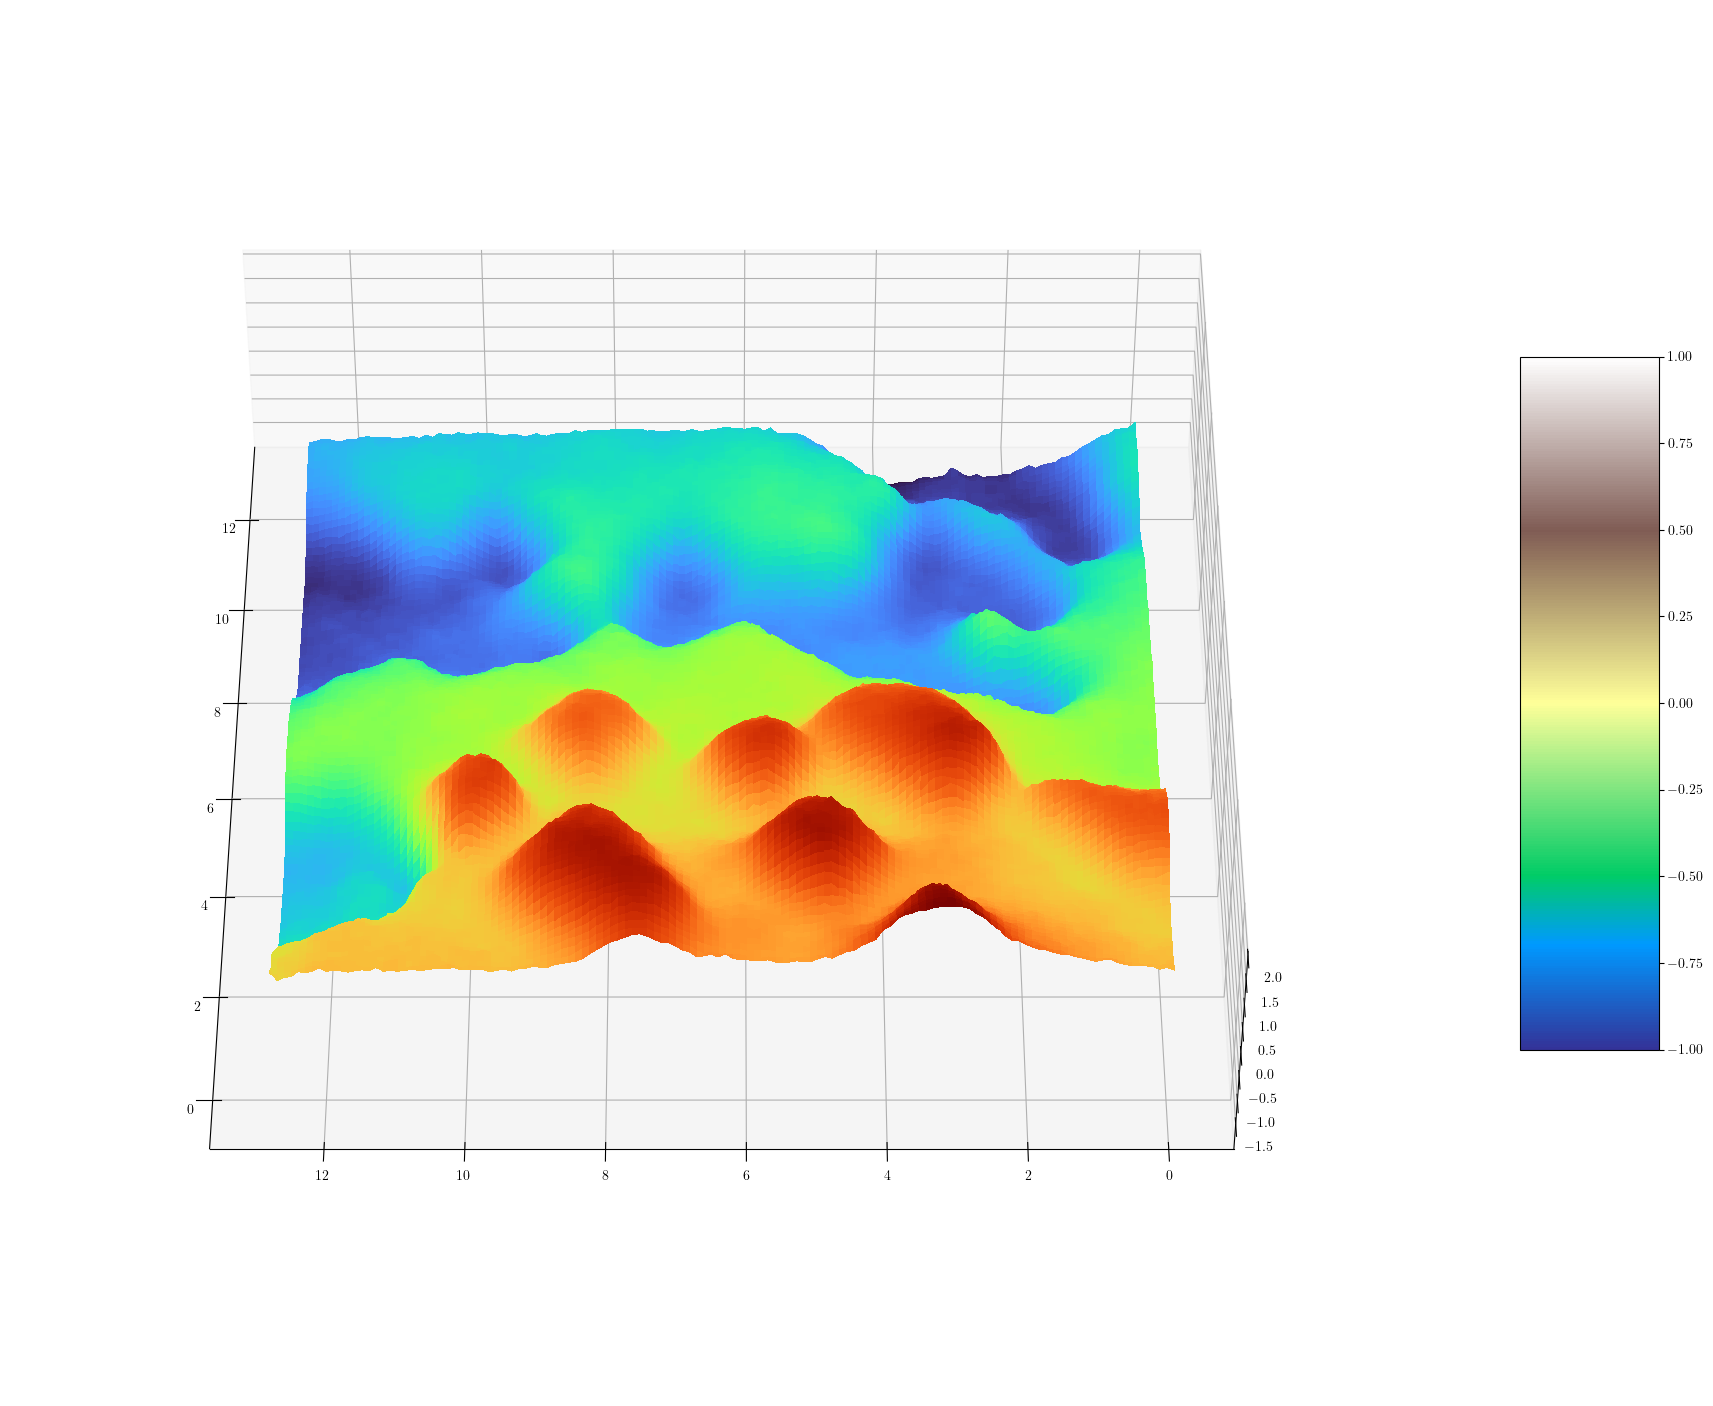

In [68]:
last_edited_samples = []
# last_edited_samples = list(last_edited_samples)
for i in range(len(all_edited_samples[1])):
    last_edited_samples.append(all_edited_samples[1][i])

save_sampling_video(np.array(last_edited_samples), "test_imgs/step_300.mp4", len(all_edited_samples[0]))

In [ ]:
original_data = original_data_sample.cpu().numpy().copy().reshape(128, 128)
last_edited_samples = []
for i in range(len(all_edited_samples)):
    for j in range(len(all_edited_samples[i])):
        last_edited_samples.append(all_edited_samples[i][j])
last_edited_samples = np.array(last_edited_samples)
print(ratio)
for id in range(len(last_edited_samples)):
    mask = masks[0][0][0].cpu().numpy()
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            dif = last_edited_samples[id][0][i][j] - original_data[i][j]
            last_edited_samples[id][0][i][j] = original_data[i][j] + dif * 1
            last_edited_samples[id][0][i][j] /= ratio
            last_edited_samples[id][0][i][j] *= 1
    last_edited_samples[id][0] = last_edited_samples[id][0] - np.min(last_edited_samples[id][0])

visualize_elevation_map(last_edited_samples[:16].reshape(-1, 128, 128), 4, 4, title="RAW")
# visualize_leveled_elevation_map(last_edited_samples[:8].reshape(-1, 128, 128), 1, 8, title="Mask Area Ratio")#, save_dir="./test_imgs/mask_0.2.svg")

# variances = []
# for last_edited_sample in last_edited_samples:
#     variances.append(np.var(last_edited_sample))
# fig, axis = plt.subplots(1, 1, figsize=(8, 5))
# axis.plot(range(50, 1000, 50), variances, marker='o')

# save_sampling_video(np.array(last_edited_samples), "test_imgs/step_300.mp4", len(all_edited_samples[0]), range(50, 1000, 50))

In [53]:
## TEST
## recursively 250 steps on image, see how things change
repeated_original_data_sample_copy = repeated_original_data_sample.clone()
all_edited_samples = []
edited_samples = []
for i in range(10):
    masks = [np.array(generate_mask_by_gradient(H, W, mask_area_ratio[ii], repeated_original_data_sample_copy.cpu().numpy().copy()[0])) for ii in range(len(mask_area_ratio))]
    masks = [torch.from_numpy(mask).view(1, 1, 128, 128).
         repeat(num_samples, 1, 1, 1).
         to("cuda").float() 
         for mask in masks]
    edited_x = editor(repeated_original_data_sample_copy, 250, keep_intermediate=False, mask=masks[0])
    edited_samples.append(edited_x[0].cpu().detach().numpy())
    repeated_original_data_sample_copy = edited_x[0].unsqueeze(dim=0).repeat(num_samples, 1, 1, 1)
all_edited_samples.append(edited_samples)

interpolation sample time step: 100%|██████████| 250/250 [00:02<00:00, 94.27it/s]


In [ ]:
all_edited_samples = np.array(all_edited_samples)
for i in range(len(all_edited_samples[0])):
    np.savetxt("/home/sp/test_map" + str(i) + ".txt", all_edited_samples[0][i].reshape(128, 128), delimiter =',')

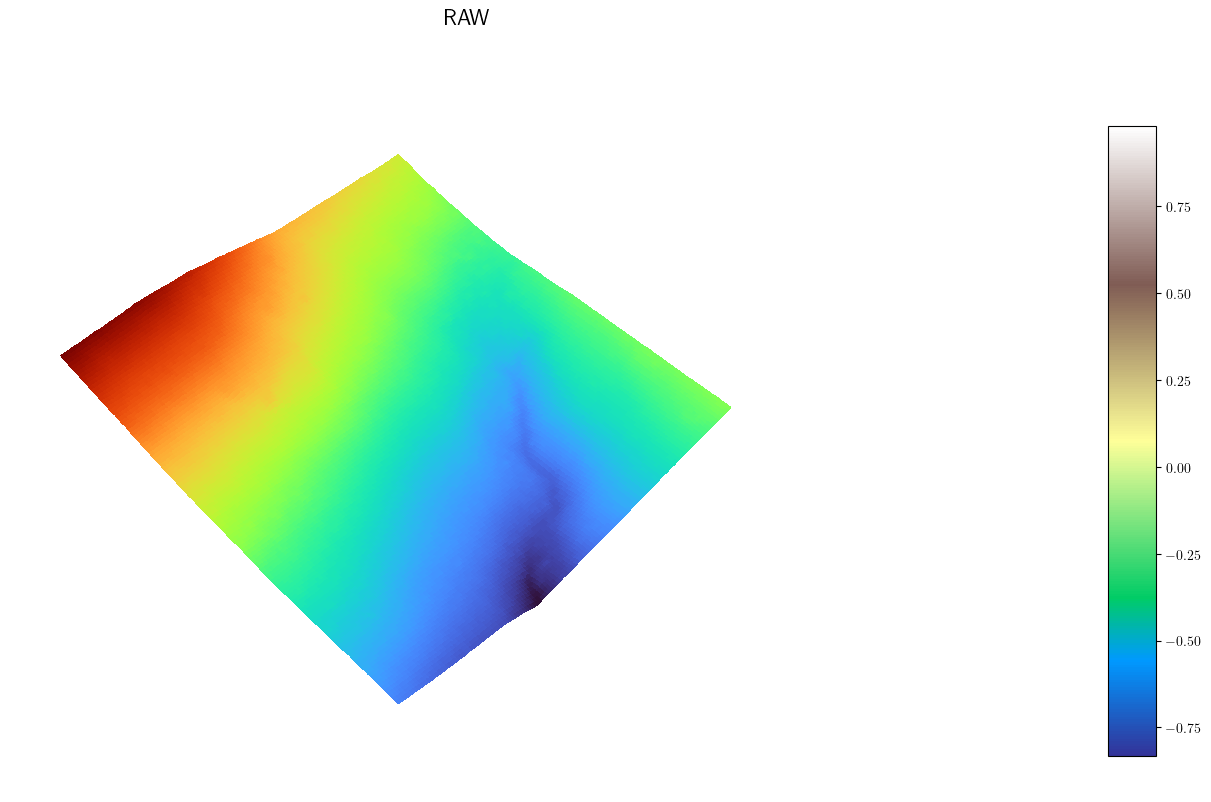

In [64]:
all_edited_samples = np.array(all_edited_samples)
row = 1
col = 1
visualize_elevation_map(all_edited_samples[0][:row*col].reshape(-1, 128, 128).copy(), row, col, title="RAW"
                        , masks=masks[0].cpu().detach().numpy()[0][0].copy(), origin=original_data_sample.cpu().numpy().copy()[0].copy())
# visualize_elevation_map_pyploy(all_edited_samples[0][:2].reshape(-1, 128, 128), 1, azim=120, title="1", masks=masks[0].cpu().detach().numpy()[0][0])

In [ ]:
all_edited_samples_copy = np.array(all_edited_samples).copy()[0]
all_edited_samples_cc = all_edited_samples_copy.copy()
for i in range(len(all_edited_samples_copy)):
    if i > 0:
        all_edited_samples_cc[i] = all_edited_samples_copy[i] - all_edited_samples_copy[i-1]
    else:
        all_edited_samples_cc[i] = all_edited_samples_copy[i] - original_data_sample.cpu().numpy().copy().reshape(128, 128)

In [ ]:
# visualize videos
save_sampling_video(all_edited_samples[0][-1][0], "test_imgs/step_300.mp4", 300)

In [ ]:
variances = np.array([
  np.var(sample_1, axis=0).sum()/masks[0][0].sum().item(),
  # np.var(sample_2, axis=0).sum()/masks[1][0].sum().item(), 
  # np.var(sample_3, axis=0).sum()/masks[2][0].sum().item(),
  # np.var(sample_4, axis=0).sum()/masks[3][0].sum().item(),
  # np.var(sample_5, axis=0).sum()/masks[4][0].sum().item(),
]) 
fig, axis = plt.subplots(1, 1, figsize=(8, 5))
axis.plot(true_mask_ratio, variances, marker='o')
print(true_mask_ratio[0], np.var(sample_1, axis=0).sum()/masks[0][0].sum())
# print(true_mask_ratio[1], np.var(sample_2, axis=0).sum()/masks[1][0].sum())
# print(true_mask_ratio[2], np.var(sample_3, axis=0).sum()/masks[2][0].sum())
# print(true_mask_ratio[3], np.var(sample_4, axis=0).sum()/masks[3][0].sum())
# print(true_mask_ratio[4], np.var(sample_5, axis=0).sum()/masks[4][0].sum())

In [ ]:
visualize_elevation_map(sample_1[:], 4, 5, azim=120, title=f"Mask Area Ratio: {true_mask_ratio[0]}", save_dir="test_imgs/mask_0.2.svg")

In [ ]:
visualize_elevation_map(sample_2[:4], 1, 4, azim=120, title=f"Mask Area Ratio: {true_mask_ratio[1]}", save_dir="media/partial_editing/mask_0.4.png")

In [ ]:
visualize_elevation_map(sample_3[:4], 1, 4, azim=120, title=f"Mask Area Ratio: {true_mask_ratio[2]}", save_dir="media/partial_editing/mask_0.6.png")

In [ ]:
visualize_elevation_map(sample_4[:4], 1, 4, azim=120, title=f"Mask Area Ratio: {true_mask_ratio[3]}", save_dir="media/partial_editing/mask_0.8.png")

In [ ]:
visualize_elevation_map(sample_5[:4], 1, 4, azim=120, title=f"Mask Area Ratio: {true_mask_ratio[4]}", save_dir="media/partial_editing/mask_1.0.png")